#Bike Sharing Demand - @satishkt, @sialan

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
from __future__ import division
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LassoLars,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.svm import SVR
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import cross_validation, linear_model
import matplotlib.pyplot as plt
from sklearn.lda import LDA
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.lda import LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.grid_search import GridSearchCV

The bike share problem is a forecasting problem where data for bike share counts is provided across multiple dimensions such as temperature, holidays,season and the time the bike was rented. The training data set provided for the count of actual bike shares for dates from 1st till the 20th of the month and the test data set was to match the actual bike shares during the rest of the month with the predicted patterns from the training set. 

The metric of evaluation was Root Mean Squared Logarithmic Error calculated as follows 
Sqrt(1/n (∑(log(pi+1)−log(ai+1))^^2))
Where:
 
n is the number of hours in the test set
pi is your predicted count
ai is the actual count
log(x) is the natural logarithm

Participants were to provide their predictions in a specified format (datetime,count) and the RMSLE determined their leaderboard ranking.

The following code loads data and sets up the test and training sets. 

In [2]:
bike_sharing_demand = pd.read_csv('./data/input/train.csv')
prediction_data = pd.read_csv('data/input/test.csv')
train_data, train_labels = bike_sharing_demand.ix[:, 'datetime':'windspeed'], bike_sharing_demand.ix[:, 'casual':]
prediction_data = prediction_data.ix[:, 'datetime':'windspeed']
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [6]:
# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
mini_bike_sharing_demand = bike_sharing_demand.ix[shuffle[:100], :]
mini_train_data, mini_train_labels = train_data.ix[shuffle[:100], :], train_labels.ix[shuffle[:100], :]
print mini_train_data.shape, mini_train_labels.shape

print train_data.columns
print train_data.dtypes
print train_labels.columns
print train_labels.dtypes

(100, 9) (100, 3)
Index([u'datetime', u'season', u'holiday', u'workingday', u'weather', u'temp', u'atemp', u'humidity', u'windspeed'], dtype='object')
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object
Index([u'casual', u'registered', u'count'], dtype='object')
casual        int64
registered    int64
count         int64
dtype: object


The easy feature engineering would be to look at the date time column more closeley, Split it up into day oof the week, hour of the day, month of the year to see if there are patterns that stand out.

In [17]:
# Let's extract the information
for dataset in (bike_sharing_demand, prediction_data):
    dataset['hour'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).hour)
    dataset['weekday'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).weekday())
    dataset['month'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).month)
    dataset['year'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).year)
bike_sharing_demand.head(5) 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,0,5,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1,5,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,2,5,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,3,5,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,4,5,1,2011


#Data Exploration and relationships between variables

As part of looking at some obvious patterns in data, we take the linear model as the base and see if any particular relationships between the data show up.

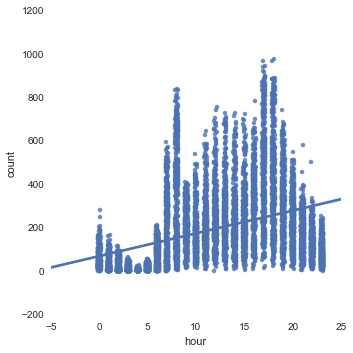

In [18]:
#This generates a linear relationship plot between the hour of the day and the actual count of bike shares

sns.lmplot("hour","count",bike_sharing_demand,x_jitter=.15)

Clearly , there is some kind of non linear relationship between hour of the count and the hour of the day, Lets apply local  weighted regression between the variables to see if it generates a better relationship between the variables.

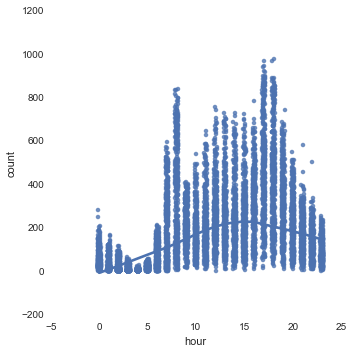

In [19]:
sns.lmplot("hour","count",bike_sharing_demand,x_jitter=.15,lowess=True)

The relationship between the hour variable and the count does not seem linear, more like a polynomial type.We could look at the average number of bikes rented per hour to see how the variable trends.

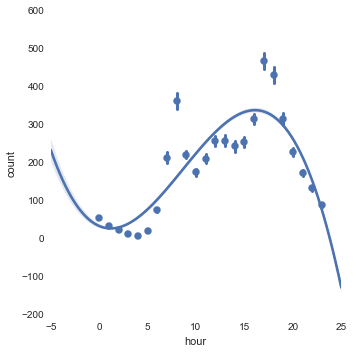

In [23]:
# Now use the mean of the count of variables rented on a given hour and use the order =3 for the hour to see any relationship
sns.lmplot("hour","count",bike_sharing_demand,order =3,x_estimator=np.mean)

Similarly we now check the relationship between the day of the week variable and the actual count of the bikes that were rented

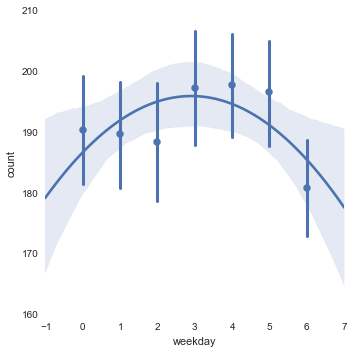

In [30]:
sns.lmplot("weekday","count",bike_sharing_demand,x_estimator = np.mean,order =2)

Perhaps using the order as 3 might help since clearly there are points which dont neatly fit against the parabola curve

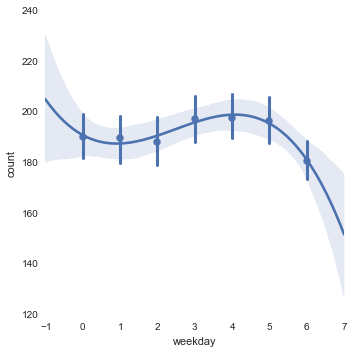

In [31]:
sns.lmplot("weekday","count",bike_sharing_demand,x_estimator = np.mean,order =3)

Relationship between the temperature of the day and count of bikes that were rented.

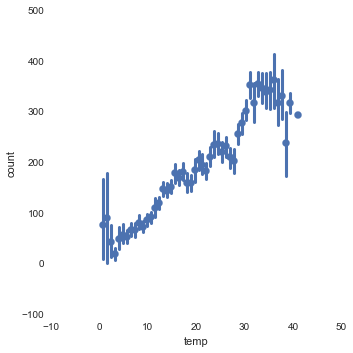

In [37]:
#Scatter plot between temp and avg bikes rented
sns.lmplot("temp", "count", bike_sharing_demand,  palette="Set1", fit_reg=False,x_estimator=np.mean);

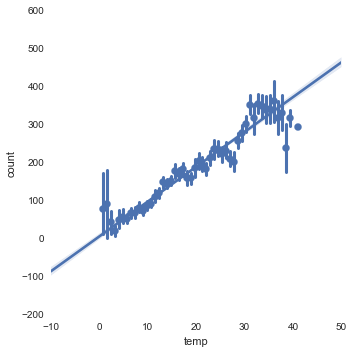

In [38]:
#Now with the regression line
sns.lmplot("temp","count",bike_sharing_demand,x_estimator = np.mean)

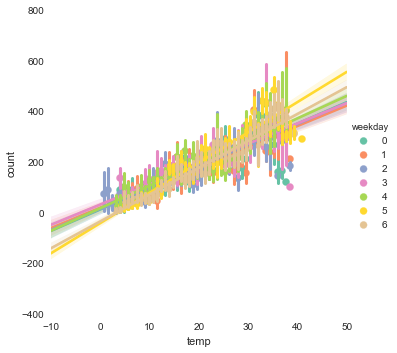

In [35]:
#Show the relationship between the avg bikes rented, weekday and the temp
sns.lmplot("temp","count",bike_sharing_demand,x_estimator = np.mean,hue="weekday",palette="Set2")

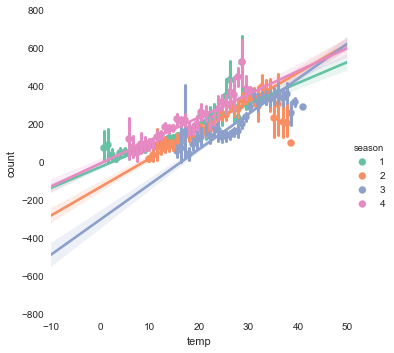

In [39]:
#Lets mix in the season with the temperature and bike share count
sns.lmplot("temp","count",bike_sharing_demand,x_estimator = np.mean,hue="season",palette="Set2")

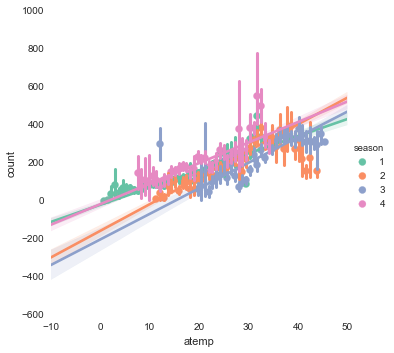

In [40]:
#Now lets look at atemp which is the 'feels like' temp, see if similar trends hold
sns.lmplot("atemp","count",bike_sharing_demand,x_estimator = np.mean,hue="season",palette="Set2")

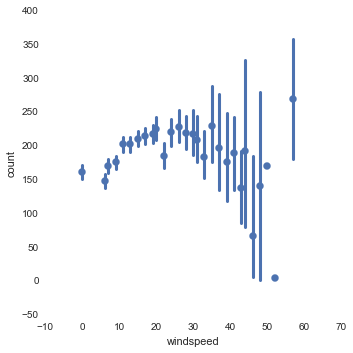

In [41]:
# Now windspeed and bike share count, a simple scatter plot
sns.lmplot("windspeed", "count", bike_sharing_demand,fit_reg=False,x_estimator=np.mean);

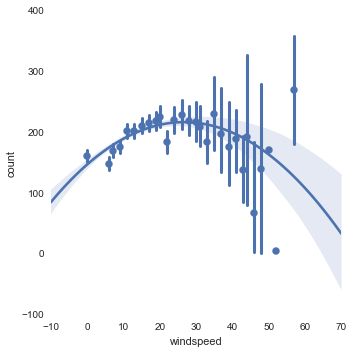

In [43]:
#With a regression line, windspeed to the order 2 
sns.lmplot("windspeed", "count", bike_sharing_demand,x_estimator=np.mean,order=2);

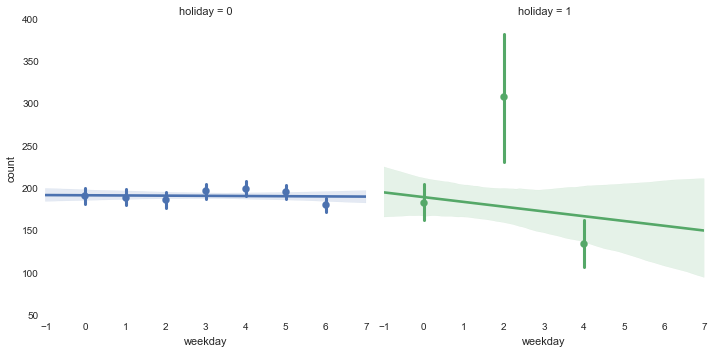

In [44]:
#Now lets look at patterns between holidays and non holidays
sns.lmplot("weekday","count",bike_sharing_demand,x_jitter=.15,col="holiday",hue="holiday",x_estimator = np.mean)

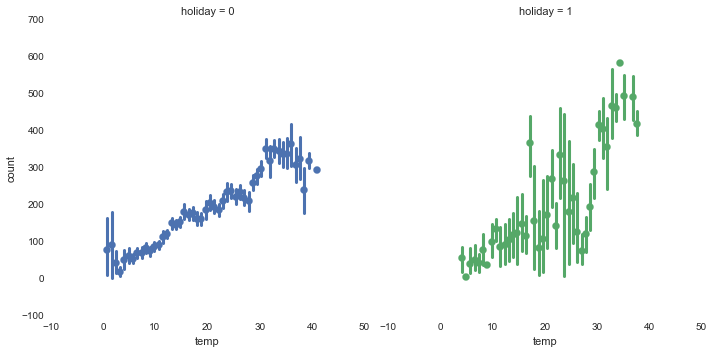

In [45]:
#Does holiday and temp show clear patterns ?
sns.lmplot("temp","count",bike_sharing_demand,x_jitter=.15,col="holiday",hue="holiday",x_estimator=np.mean,fit_reg=False)

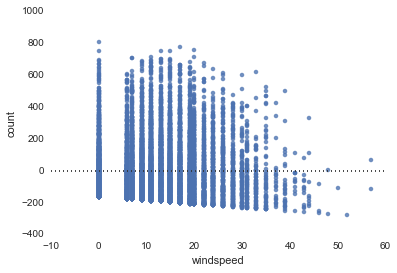

In [48]:
#Lets look at some residual plots to see if there are any major variables that explain most of variation. 
sns.residplot("windspeed", "count", bike_sharing_demand);
#Windspeed on its own does not help much

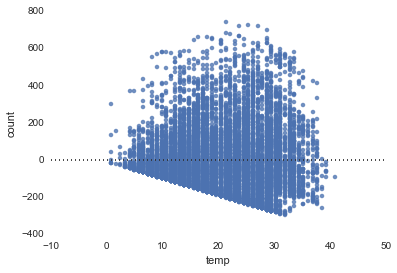

In [49]:
sns.residplot("temp", "count", bike_sharing_demand);
#Neither does temperature

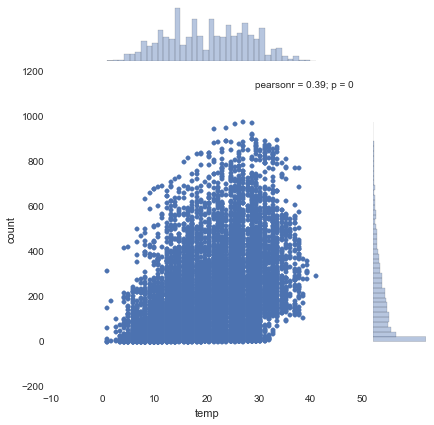

In [50]:
#Correlation exists,but is still week.
sns.jointplot("temp", "count", bike_sharing_demand);

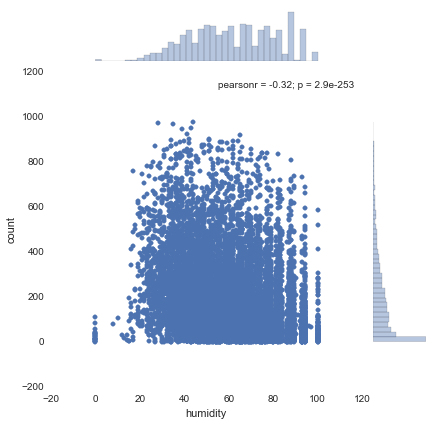

In [51]:
sns.jointplot("humidity", "count", bike_sharing_demand);

#Modelling Time  - Lets try a few models.

The key measure we are interested in, apart from the actual accuracy with training and test data, is the RMSLE. As defined earlier, this is the root mean square log error of the difference between the predicted value and the actual value. So lets first build out that metric.

In [4]:
#Build out the cross validation split.
cv = cross_validation.ShuffleSplit(train_data.shape[0], n_iter=10, random_state=0)
np.random.seed(0)


# Define the Root-Mean-Squared-Log Error function for scoring predictions
def rmsle(actual_values, predicted_values):
    squared_log_errors = (np.log(np.array(predicted_values) + 1) - np.log(np.array(actual_values) + 1)) ** 2
    mean_squared_errors = np.nansum(squared_log_errors) / len(squared_log_errors)
    return np.sqrt(mean_squared_errors)

#Here is our training and predicting boiler plate that takes in a model and runs through the cross validation loop.
def train_predict(model,clf):
    train_scores,test_scores =[],[]
    for i, (train_index, test_index) in enumerate(cv):
        x_train, y_train = train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count']
        x_test, y_test = train_data.ix[test_index, 'season':], train_labels.ix[test_index, 'count']
        clf.fit(x_train, y_train)
        predicted_values = clf.predict(x_test)
        rmse_score =rmsle(y_test, predicted_values)
        train_score = clf.score(x_train, y_train)
        test_score = clf.score(x_test, y_test)
        print("%s : Loop: %d,RMSLE: %.3f,Train Score %.3f,Test Score %.3f" %(model,i, rmsle(y_test, predicted_values),train_score,test_score))
        train_scores.append(train_score)
        test_scores.append(test_score)
    #print scores
    #print [score for score in scores]
    print("Mean Train Score for %s %.3f , Mean Test Score %.3f" % (model,np.mean(train_scores),np.mean(test_scores)))

# LDA 

In [55]:
clf_lda = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', LDA())
])

train_predict('LDA',clf_lda)

LDA : Loop: 0,RMSLE: 1.664,Train Score 0.045,Test Score 0.021
LDA : Loop: 1,RMSLE: 1.495,Train Score 0.046,Test Score 0.024
LDA : Loop: 2,RMSLE: 1.631,Train Score 0.046,Test Score 0.020
LDA : Loop: 3,RMSLE: 1.559,Train Score 0.046,Test Score 0.016
LDA : Loop: 4,RMSLE: 1.544,Train Score 0.046,Test Score 0.018
LDA : Loop: 5,RMSLE: 1.671,Train Score 0.047,Test Score 0.016
LDA : Loop: 6,RMSLE: 1.618,Train Score 0.045,Test Score 0.015
LDA : Loop: 7,RMSLE: 1.657,Train Score 0.046,Test Score 0.030
LDA : Loop: 8,RMSLE: 1.630,Train Score 0.049,Test Score 0.011
LDA : Loop: 9,RMSLE: 1.598,Train Score 0.046,Test Score 0.022
Mean Train Score for LDA 0.046 , Mean Test Score 0.019


# Linear Model

In [57]:
clf_linear = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', LinearRegression())
])
train_predict('Linear ',clf_linear)

Linear  : Loop: 0,RMSLE: 1.195,Train Score 0.395,Test Score 0.389
Linear  : Loop: 1,RMSLE: 1.170,Train Score 0.391,Test Score 0.424
Linear  : Loop: 2,RMSLE: 1.184,Train Score 0.398,Test Score 0.361
Linear  : Loop: 3,RMSLE: 1.138,Train Score 0.392,Test Score 0.410
Linear  : Loop: 4,RMSLE: 1.087,Train Score 0.394,Test Score 0.395
Linear  : Loop: 5,RMSLE: 1.133,Train Score 0.396,Test Score 0.372
Linear  : Loop: 6,RMSLE: 1.164,Train Score 0.395,Test Score 0.388
Linear  : Loop: 7,RMSLE: 1.157,Train Score 0.397,Test Score 0.372
Linear  : Loop: 8,RMSLE: 1.120,Train Score 0.395,Test Score 0.380
Linear  : Loop: 9,RMSLE: 1.140,Train Score 0.397,Test Score 0.367
Mean Train Score for Linear  0.395 , Mean Test Score 0.386


#Polynomial Regression with degree 3

In [59]:
clf_poly = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', LinearRegression())
])
train_predict('Polynomial Regression degree 3 ',clf_poly)

Polynomial Regression degree 3  : Loop: 0,RMSLE: 0.994,Train Score 0.655,Test Score 0.633
Polynomial Regression degree 3  : Loop: 1,RMSLE: 1.002,Train Score 0.656,Test Score 0.623
Polynomial Regression degree 3  : Loop: 2,RMSLE: 0.982,Train Score 0.657,Test Score 0.610
Polynomial Regression degree 3  : Loop: 3,RMSLE: 0.961,Train Score 0.655,Test Score 0.640
Polynomial Regression degree 3  : Loop: 4,RMSLE: 0.945,Train Score 0.657,Test Score 0.609
Polynomial Regression degree 3  : Loop: 5,RMSLE: 0.882,Train Score 0.656,Test Score 0.603
Polynomial Regression degree 3  : Loop: 6,RMSLE: 0.919,Train Score 0.657,Test Score 0.607
Polynomial Regression degree 3  : Loop: 7,RMSLE: 0.937,Train Score 0.657,Test Score 0.617
Polynomial Regression degree 3  : Loop: 8,RMSLE: inf,Train Score 0.657,Test Score 0.605
Polynomial Regression degree 3  : Loop: 9,RMSLE: inf,Train Score 0.659,Test Score 0.598
Mean Train Score for Polynomial Regression degree 3  0.657 , Mean Test Score 0.615


#KNN Regressor

In [60]:
clf_knn = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', KNeighborsRegressor(n_neighbors=5))
])
train_predict('KNN ',clf_knn)

KNN  : Loop: 0,RMSLE: 0.901,Train Score 0.770,Test Score 0.608
KNN  : Loop: 1,RMSLE: 0.879,Train Score 0.768,Test Score 0.655
KNN  : Loop: 2,RMSLE: 0.875,Train Score 0.770,Test Score 0.642
KNN  : Loop: 3,RMSLE: 0.884,Train Score 0.766,Test Score 0.651
KNN  : Loop: 4,RMSLE: 0.857,Train Score 0.764,Test Score 0.645
KNN  : Loop: 5,RMSLE: 0.871,Train Score 0.769,Test Score 0.627
KNN  : Loop: 6,RMSLE: 0.882,Train Score 0.765,Test Score 0.615
KNN  : Loop: 7,RMSLE: 0.866,Train Score 0.769,Test Score 0.601
KNN  : Loop: 8,RMSLE: 0.850,Train Score 0.767,Test Score 0.630
KNN  : Loop: 9,RMSLE: 0.859,Train Score 0.766,Test Score 0.624
Mean Train Score for KNN  0.767 , Mean Test Score 0.630


# Ridge Regression with polynomial features with degree 3

In [62]:
clf_ridge = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
                    normalize=False, solver='auto', tol=0.001))
])
train_predict('Ridge-degree 3',clf_ridge)

Ridge-degree 3 : Loop: 0,RMSLE: 1.009,Train Score 0.635,Test Score 0.626
Ridge-degree 3 : Loop: 1,RMSLE: 1.018,Train Score 0.635,Test Score 0.623
Ridge-degree 3 : Loop: 2,RMSLE: 0.972,Train Score 0.637,Test Score 0.606
Ridge-degree 3 : Loop: 3,RMSLE: 0.986,Train Score 0.634,Test Score 0.635
Ridge-degree 3 : Loop: 4,RMSLE: 0.949,Train Score 0.636,Test Score 0.611
Ridge-degree 3 : Loop: 5,RMSLE: 0.923,Train Score 0.636,Test Score 0.610
Ridge-degree 3 : Loop: 6,RMSLE: 0.963,Train Score 0.637,Test Score 0.606
Ridge-degree 3 : Loop: 7,RMSLE: 0.950,Train Score 0.636,Test Score 0.614
Ridge-degree 3 : Loop: 8,RMSLE: 1.017,Train Score 0.637,Test Score 0.597
Ridge-degree 3 : Loop: 9,RMSLE: 0.968,Train Score 0.638,Test Score 0.590
Mean Train Score for Ridge-degree 3 0.636 , Mean Test Score 0.612


# Lasso with Polynomial features with degree 3

In [64]:
clf_lasso = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
                    normalize=False, positive=False, precompute=False,
                    tol=0.0001, warm_start=False))
])
train_predict('Lasso-degree 3',clf_lasso)

Lasso-degree 3 : Loop: 0,RMSLE: 1.022,Train Score 0.596,Test Score 0.597
Lasso-degree 3 : Loop: 1,RMSLE: 1.019,Train Score 0.596,Test Score 0.611
Lasso-degree 3 : Loop: 2,RMSLE: 0.999,Train Score 0.598,Test Score 0.578
Lasso-degree 3 : Loop: 3,RMSLE: 1.023,Train Score 0.596,Test Score 0.609
Lasso-degree 3 : Loop: 4,RMSLE: 0.980,Train Score 0.597,Test Score 0.594
Lasso-degree 3 : Loop: 5,RMSLE: 0.985,Train Score 0.599,Test Score 0.578
Lasso-degree 3 : Loop: 6,RMSLE: 0.989,Train Score 0.599,Test Score 0.585
Lasso-degree 3 : Loop: 7,RMSLE: 0.966,Train Score 0.598,Test Score 0.583
Lasso-degree 3 : Loop: 8,RMSLE: 0.989,Train Score 0.598,Test Score 0.582
Lasso-degree 3 : Loop: 9,RMSLE: 0.991,Train Score 0.600,Test Score 0.568
Mean Train Score for Lasso-degree 3 0.598 , Mean Test Score 0.589


#Lasso Lars

In [66]:
clf_lassolars = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', LassoLars(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
                    normalize=False, precompute=False))
])
train_predict('Lasso-lars 3',clf_lassolars)

Lasso-lars 3 : Loop: 0,RMSLE: 1.050,Train Score 0.596,Test Score 0.597
Lasso-lars 3 : Loop: 1,RMSLE: 1.019,Train Score 0.596,Test Score 0.611
Lasso-lars 3 : Loop: 2,RMSLE: 0.999,Train Score 0.598,Test Score 0.578
Lasso-lars 3 : Loop: 3,RMSLE: 1.023,Train Score 0.596,Test Score 0.609
Lasso-lars 3 : Loop: 4,RMSLE: 0.979,Train Score 0.597,Test Score 0.594
Lasso-lars 3 : Loop: 5,RMSLE: 0.984,Train Score 0.599,Test Score 0.578
Lasso-lars 3 : Loop: 6,RMSLE: 0.990,Train Score 0.599,Test Score 0.585
Lasso-lars 3 : Loop: 7,RMSLE: 0.966,Train Score 0.598,Test Score 0.583
Lasso-lars 3 : Loop: 8,RMSLE: 0.989,Train Score 0.598,Test Score 0.582
Lasso-lars 3 : Loop: 9,RMSLE: 0.990,Train Score 0.600,Test Score 0.568
Mean Train Score for Lasso-lars 3 0.598 , Mean Test Score 0.589


#Elastic Net

In [68]:
clf_elastic_net = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
                    normalize=False, precompute=False))
])
train_predict('Elastic Net',clf_elastic_net)

Elastic Net : Loop: 0,RMSLE: 1.283,Train Score 0.419,Test Score 0.409
Elastic Net : Loop: 1,RMSLE: 1.249,Train Score 0.416,Test Score 0.438
Elastic Net : Loop: 2,RMSLE: 1.270,Train Score 0.421,Test Score 0.388
Elastic Net : Loop: 3,RMSLE: 1.249,Train Score 0.416,Test Score 0.431
Elastic Net : Loop: 4,RMSLE: 1.191,Train Score 0.418,Test Score 0.416
Elastic Net : Loop: 5,RMSLE: 1.215,Train Score 0.420,Test Score 0.409
Elastic Net : Loop: 6,RMSLE: 1.240,Train Score 0.418,Test Score 0.420
Elastic Net : Loop: 7,RMSLE: 1.231,Train Score 0.420,Test Score 0.399
Elastic Net : Loop: 8,RMSLE: 1.216,Train Score 0.419,Test Score 0.398
Elastic Net : Loop: 9,RMSLE: 1.245,Train Score 0.421,Test Score 0.397
Mean Train Score for Elastic Net 0.419 , Mean Test Score 0.411


# Support Vector Regression - RBF

In [69]:
clf_svrbf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', SVR(kernel='rbf', C=1e3, gamma=0.1))
])
train_predict('SVR - RBF',clf_svrbf)

SVR - RBF : Loop: 0,RMSLE: 0.945,Train Score 0.515,Test Score 0.505
SVR - RBF : Loop: 1,RMSLE: 0.928,Train Score 0.513,Test Score 0.531
SVR - RBF : Loop: 2,RMSLE: 0.977,Train Score 0.520,Test Score 0.465
SVR - RBF : Loop: 3,RMSLE: 0.963,Train Score 0.514,Test Score 0.532
SVR - RBF : Loop: 4,RMSLE: 0.911,Train Score 0.514,Test Score 0.495
SVR - RBF : Loop: 5,RMSLE: 0.919,Train Score 0.515,Test Score 0.509
SVR - RBF : Loop: 6,RMSLE: 0.904,Train Score 0.515,Test Score 0.508
SVR - RBF : Loop: 7,RMSLE: 0.913,Train Score 0.515,Test Score 0.489
SVR - RBF : Loop: 8,RMSLE: 0.951,Train Score 0.516,Test Score 0.477
SVR - RBF : Loop: 9,RMSLE: 0.937,Train Score 0.520,Test Score 0.484
Mean Train Score for SVR - RBF 0.516 , Mean Test Score 0.500


#Support Vector Regression - Linear Kernel

In [71]:
clf_svrlin = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', SVR(kernel='linear', C=1e3))
])
train_predict('SVR - Linear kernel',clf_svrlin)

SVR - Linear kernel : Loop: 0,RMSLE: 1.086,Train Score 0.338,Test Score 0.325
SVR - Linear kernel : Loop: 1,RMSLE: 1.032,Train Score 0.334,Test Score 0.373
SVR - Linear kernel : Loop: 2,RMSLE: 1.092,Train Score 0.343,Test Score 0.302
SVR - Linear kernel : Loop: 3,RMSLE: 1.054,Train Score 0.336,Test Score 0.363
SVR - Linear kernel : Loop: 4,RMSLE: 0.996,Train Score 0.335,Test Score 0.321
SVR - Linear kernel : Loop: 5,RMSLE: 1.035,Train Score 0.339,Test Score 0.328
SVR - Linear kernel : Loop: 6,RMSLE: 1.082,Train Score 0.335,Test Score 0.338
SVR - Linear kernel : Loop: 7,RMSLE: 1.055,Train Score 0.340,Test Score 0.310
SVR - Linear kernel : Loop: 8,RMSLE: 1.060,Train Score 0.340,Test Score 0.303
SVR - Linear kernel : Loop: 9,RMSLE: 1.063,Train Score 0.342,Test Score 0.318
Mean Train Score for SVR - Linear kernel 0.338 , Mean Test Score 0.328


#Support Vector Regression - Polynomial Kernel

In [72]:
clf_svrpoly = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', SVR(kernel='poly', C=1e3, degree=3))
])
train_predict('SVR - Polynomial kernel',clf_svrpoly)

SVR - Polynomial kernel : Loop: 0,RMSLE: 1.153,Train Score 0.293,Test Score 0.283
SVR - Polynomial kernel : Loop: 1,RMSLE: 1.115,Train Score 0.291,Test Score 0.324
SVR - Polynomial kernel : Loop: 2,RMSLE: 1.145,Train Score 0.299,Test Score 0.266
SVR - Polynomial kernel : Loop: 3,RMSLE: 1.121,Train Score 0.291,Test Score 0.316
SVR - Polynomial kernel : Loop: 4,RMSLE: 1.075,Train Score 0.292,Test Score 0.270
SVR - Polynomial kernel : Loop: 5,RMSLE: 1.096,Train Score 0.294,Test Score 0.295
SVR - Polynomial kernel : Loop: 6,RMSLE: 1.117,Train Score 0.291,Test Score 0.303
SVR - Polynomial kernel : Loop: 7,RMSLE: 1.134,Train Score 0.296,Test Score 0.277
SVR - Polynomial kernel : Loop: 8,RMSLE: 1.112,Train Score 0.295,Test Score 0.253
SVR - Polynomial kernel : Loop: 9,RMSLE: 1.118,Train Score 0.297,Test Score 0.279
Mean Train Score for SVR - Polynomial kernel 0.294 , Mean Test Score 0.287


#Random Forest Regressor

In [73]:
rf = RandomForestRegressor(random_state=0, n_estimators=100)
clf_rf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', rf)
])
train_predict('RF Regressor',clf_rf)

RF Regressor : Loop: 0,RMSLE: 0.444,Train Score 0.988,Test Score 0.914
RF Regressor : Loop: 1,RMSLE: 0.400,Train Score 0.988,Test Score 0.927
RF Regressor : Loop: 2,RMSLE: 0.397,Train Score 0.988,Test Score 0.902
RF Regressor : Loop: 3,RMSLE: 0.408,Train Score 0.988,Test Score 0.907
RF Regressor : Loop: 4,RMSLE: 0.411,Train Score 0.988,Test Score 0.911
RF Regressor : Loop: 5,RMSLE: 0.412,Train Score 0.988,Test Score 0.917
RF Regressor : Loop: 6,RMSLE: 0.389,Train Score 0.988,Test Score 0.907
RF Regressor : Loop: 7,RMSLE: 0.424,Train Score 0.988,Test Score 0.911
RF Regressor : Loop: 8,RMSLE: 0.416,Train Score 0.988,Test Score 0.924
RF Regressor : Loop: 9,RMSLE: 0.424,Train Score 0.988,Test Score 0.904
Mean Train Score for RF Regressor 0.988 , Mean Test Score 0.912


#ExtraTree Regressor

In [74]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(random_state=0, n_estimators=300,max_depth=300)
clf_etr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', etr)
])
train_predict('Extra Tre Regressor',clf_etr)

Extra Tre Regressor : Loop: 0,RMSLE: 0.446,Train Score 1.000,Test Score 0.918
Extra Tre Regressor : Loop: 1,RMSLE: 0.405,Train Score 1.000,Test Score 0.932
Extra Tre Regressor : Loop: 2,RMSLE: 0.389,Train Score 1.000,Test Score 0.918
Extra Tre Regressor : Loop: 3,RMSLE: 0.405,Train Score 1.000,Test Score 0.921
Extra Tre Regressor : Loop: 4,RMSLE: 0.395,Train Score 1.000,Test Score 0.928
Extra Tre Regressor : Loop: 5,RMSLE: 0.394,Train Score 1.000,Test Score 0.927
Extra Tre Regressor : Loop: 6,RMSLE: 0.399,Train Score 1.000,Test Score 0.921
Extra Tre Regressor : Loop: 7,RMSLE: 0.411,Train Score 1.000,Test Score 0.921
Extra Tre Regressor : Loop: 8,RMSLE: 0.397,Train Score 1.000,Test Score 0.931
Extra Tre Regressor : Loop: 9,RMSLE: 0.398,Train Score 1.000,Test Score 0.921
Mean Train Score for Extra Tre Regressor 1.000 , Mean Test Score 0.924


#Adaboost

In [75]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor()
clf_ada = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', adaboost)
])
train_predict('Adaboost',clf_ada)

Adaboost : Loop: 0,RMSLE: 1.366,Train Score 0.482,Test Score 0.473
Adaboost : Loop: 1,RMSLE: 1.399,Train Score 0.445,Test Score 0.450
Adaboost : Loop: 2,RMSLE: 1.402,Train Score 0.437,Test Score 0.455
Adaboost : Loop: 3,RMSLE: 1.388,Train Score 0.453,Test Score 0.442
Adaboost : Loop: 4,RMSLE: 1.368,Train Score 0.445,Test Score 0.445
Adaboost : Loop: 5,RMSLE: 1.315,Train Score 0.499,Test Score 0.439
Adaboost : Loop: 6,RMSLE: 1.359,Train Score 0.471,Test Score 0.417
Adaboost : Loop: 7,RMSLE: 1.352,Train Score 0.468,Test Score 0.455
Adaboost : Loop: 8,RMSLE: 1.302,Train Score 0.482,Test Score 0.510
Adaboost : Loop: 9,RMSLE: 1.423,Train Score 0.443,Test Score 0.424
Mean Train Score for Adaboost 0.462 , Mean Test Score 0.451


# Gradient Boosting Regressor

In [5]:
gbm = GradientBoostingRegressor(n_estimators=100, max_depth=6)

clf_gbm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', gbm)
])
train_predict('Gradient Boost',clf_gbm)

Gradient Boost : Loop: 0,RMSLE: 1.320,Train Score 0.549,Test Score 0.320
Gradient Boost : Loop: 1,RMSLE: 1.292,Train Score 0.555,Test Score 0.345
Gradient Boost : Loop: 2,RMSLE: 1.325,Train Score 0.557,Test Score 0.314
Gradient Boost : Loop: 3,RMSLE: 1.322,Train Score 0.548,Test Score 0.377
Gradient Boost : Loop: 4,RMSLE: 1.242,Train Score 0.554,Test Score 0.348
Gradient Boost : Loop: 5,RMSLE: 1.267,Train Score 0.557,Test Score 0.298
Gradient Boost : Loop: 6,RMSLE: 1.280,Train Score 0.564,Test Score 0.322
Gradient Boost : Loop: 7,RMSLE: 1.296,Train Score 0.560,Test Score 0.301
Gradient Boost : Loop: 8,RMSLE: 1.270,Train Score 0.550,Test Score 0.343
Gradient Boost : Loop: 9,RMSLE: 1.286,Train Score 0.556,Test Score 0.320
Mean Train Score for Gradient Boost 0.555 , Mean Test Score 0.329


#Adding Some Features

In [7]:
# TODO: Add Sliding Windows
# Add windowed features (simple moving average) for weather, temp, atemp, humidity, and windspeed
train_data_windowed_features_three = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 3, 'boxcar')
train_data_windowed_features_six = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 6, 'boxcar')
train_data_windowed_features_twelve = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 12, 'boxcar')
train_data_windowed_features_twentyfour = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 24, 'boxcar')
train_data_windowed_features_fourtyeight = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 48, 'boxcar')

prediction_data_windowed_features_three = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 3, 'boxcar')
prediction_data_windowed_features_six = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 6, 'boxcar')
prediction_data_windowed_features_twelve = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 12, 'boxcar')
prediction_data_windowed_features_twentyfour = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 24, 'boxcar')
prediction_data_windowed_features_fourtyeight = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 48, 'boxcar')

train_data_combined = train_data.copy(deep=False)
prediction_data_combined = train_data.copy(deep=False)

train_data_combined['temp_w3'] = train_data_windowed_features_three['temp']
train_data_combined['temp_w6'] = train_data_windowed_features_six['temp']
train_data_combined['temp_w12'] = train_data_windowed_features_twelve['temp']
train_data_combined['temp_w24'] = train_data_windowed_features_twentyfour['temp']
train_data_combined['temp_w48'] = train_data_windowed_features_fourtyeight['temp']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['temp']))

train_data_combined['atemp_w3'] = train_data_windowed_features_three['atemp']
train_data_combined['atemp_w6'] = train_data_windowed_features_six['atemp']
train_data_combined['atemp_w12'] = train_data_windowed_features_twelve['atemp']
train_data_combined['atemp_w24'] = train_data_windowed_features_twentyfour['atemp']
train_data_combined['atemp_w48'] = train_data_windowed_features_fourtyeight['atemp']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['atemp']))

train_data_combined['humidity_w3'] = train_data_windowed_features_three['humidity']
train_data_combined['humidity_w6'] = train_data_windowed_features_six['humidity']
train_data_combined['humidity_w12'] = train_data_windowed_features_twelve['humidity']
train_data_combined['humidity_w24'] = train_data_windowed_features_twentyfour['humidity']
train_data_combined['humidity_w48'] = train_data_windowed_features_fourtyeight['humidity']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['humidity']))

train_data_combined['windspeed_w3'] = train_data_windowed_features_three['windspeed']
train_data_combined['windspeed_w6'] = train_data_windowed_features_six['windspeed']
train_data_combined['windspeed_w12'] = train_data_windowed_features_twelve['windspeed']
train_data_combined['windspeed_w24'] = train_data_windowed_features_twentyfour['windspeed']
train_data_combined['windspeed_w48'] = train_data_windowed_features_fourtyeight['windspeed']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['windspeed']))

prediction_data_combined['temp_w3'] = train_data_windowed_features_three['temp']
prediction_data_combined['temp_w6'] = train_data_windowed_features_six['temp']
prediction_data_combined['temp_w12'] = train_data_windowed_features_twelve['temp']
prediction_data_combined['temp_w24'] = train_data_windowed_features_twentyfour['temp']
prediction_data_combined['temp_w48'] = train_data_windowed_features_fourtyeight['temp']
prediction_data_combined = prediction_data_combined.apply(lambda x: x.fillna(value=train_data_combined['temp']))

prediction_data_combined['atemp_w3'] = train_data_windowed_features_three['atemp']
prediction_data_combined['atemp_w6'] = train_data_windowed_features_six['atemp']
prediction_data_combined['atemp_w12'] = train_data_windowed_features_twelve['atemp']
prediction_data_combined['atemp_w24'] = train_data_windowed_features_twentyfour['atemp']
prediction_data_combined['atemp_w48'] = train_data_windowed_features_fourtyeight['atemp']
prediction_data_combined = prediction_data_combined.apply(lambda x: x.fillna(value=train_data_combined['atemp']))

prediction_data_combined['humidity_w3'] = train_data_windowed_features_three['humidity']
prediction_data_combined['humidity_w6'] = train_data_windowed_features_six['humidity']
prediction_data_combined['humidity_w12'] = train_data_windowed_features_twelve['humidity']
prediction_data_combined['humidity_w24'] = train_data_windowed_features_twentyfour['humidity']
prediction_data_combined['humidity_w48'] = train_data_windowed_features_fourtyeight['humidity']
prediction_data_combined = prediction_data_combined.apply(lambda x: x.fillna(value=train_data_combined['humidity']))

prediction_data_combined['windspeed_w3'] = train_data_windowed_features_three['windspeed']
prediction_data_combined['windspeed_w6'] = train_data_windowed_features_six['windspeed']
prediction_data_combined['windspeed_w12'] = train_data_windowed_features_twelve['windspeed']
prediction_data_combined['windspeed_w24'] = train_data_windowed_features_twentyfour['windspeed']
prediction_data_combined['windspeed_w48'] = train_data_windowed_features_fourtyeight['windspeed']
prediction_data_combined = prediction_data_combined.apply(lambda x: x.fillna(value=train_data_combined['windspeed']))

#Recursive Feature Elemenation

#Tuning RF Model

In [10]:
rf = RandomForestRegressor()

param_grid = {'n_estimators': [100, 300, 500, 700, 1000], 'max_depth': [None, 1, 2, 3, 5], 'min_samples_split': [1, 2, 3, 5]}
clf_rf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer()),
    ('model', rf)
])

model = GridSearchCV(clf_rf, param_grid=param_grid)
train_predict('RF Regressor', model)

ValueError: Invalid parameter n_estimators for estimator Pipeline